In [1]:
import imp
import pickle
import os
import sys
import time

import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interact,fixed,IntSlider
from IPython.display import SVG
from matplotlib import rcParams
from matplotlib.colors import hex2color
from rdkit import Chem, rdBase
from rdkit.Chem import rdFMCS, Draw, PandasTools, AllChem, DataStructs, Descriptors
from rdkit.Chem import rdSubstructLibrary
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit import DataStructs

print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Sklearn version:', sklearn.__version__)
print('Seaborn version:', sns.__version__)

RDKit version:  2020.09.1
Pandas version: 1.1.3
Numpy version: 1.19.2
MatplotLib version: 3.3.2
Sklearn version: 0.23.2
Seaborn version: 0.11.0


In [2]:
import automated_series_classification
# imp.reload(automated_series_classification)
from automated_series_classification import utilsDataPrep
from automated_series_classification import mainSeriesClassification
from automated_series_classification import utilsDrawing
from automated_series_classification import UPGMAclustering
imp.reload(utilsDataPrep)
imp.reload(mainSeriesClassification)
imp.reload(UPGMAclustering)

<module 'automated_series_classification.UPGMAclustering' from '/home/glandrum/Code/AutomatedSeriesClassification/src/automated_series_classification/UPGMAclustering.py'>

Load ChEMBL database for substructure matching (constructed during data preprocessing)

In [3]:
%%time
with open('./data/chembl27_sssdata.pkl','rb') as file:
    chembldb = pickle.load(file)
    

CPU times: user 19 s, sys: 660 ms, total: 19.6 s
Wall time: 19.6 s


In [4]:
%%time
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.PatternHolder()
for smi,fp in chembldb:
    mols.AddSmiles(smi)
    fps.AddFingerprint(fp)
chembl_library = rdSubstructLibrary.SubstructLibrary(mols,fps)
chembldb = None
print(f"The library has {len(chembl_library)} molecules.")

The library has 1855322 molecules.
CPU times: user 2.57 s, sys: 128 ms, total: 2.69 s
Wall time: 2.7 s


In [5]:
Nchembl = len(chembl_library)

Define Parameters, note that flimit corresponds to the specificity limit E(p) as described in the paper

TIPS:dbpath is not automatically updated so if you would like to try to analyze different dataset, you should remove rdk_db or define dbpath by different name

In [6]:
flimit=1e-3
MinClusterSize=15 #20
proj='CDK2Kinase'
dbpath='./rdk_db'
datapath='./{0}/'.format(proj)
filename = 'moldata_preprocessed.csv'
smilesCol = 'Smiles'
idCol = 'ID'

In [7]:
import glob
for fn in glob.glob('./ChEMBL_ki/CHEMBL*gz'):
    df = pd.read_csv(fn)
    print(fn,len(df),len(set(df['doc_id'])))


./ChEMBL_ki/CHEMBL1898_Ki_set.csv.gz 560 76
./ChEMBL_ki/CHEMBL1889_Ki_set.csv.gz 552 43
./ChEMBL_ki/CHEMBL1821_Ki_set.csv.gz 463 63
./ChEMBL_ki/CHEMBL1867_Ki_set.csv.gz 560 79
./ChEMBL_ki/CHEMBL1875_Ki_set.csv.gz 377 32
./ChEMBL_ki/CHEMBL1855_Ki_set.csv.gz 403 17


In [8]:
len(set(df['doc_id']))

17

In [10]:
flimit=1e-3
MinClusterSize=10 #20
proj='ChEMBL_ki'
tgt = 'CHEMBL1855'
dbpath=f'ChEMBL_ki/{tgt}_db'
datapath=f'./{proj}/'
filename = f'{tgt}_Ki_set.csv.gz'
smilesCol = 'canonical_smiles'
idCol = 'chembl_id'

In [11]:
!rm {dbpath}

### UPGMA classification

Set "calcDists" to True only if the pairwise molecular distance matrix for clustering is not calculated yet (this will take a while). Set "calcScores" only if you are interested in the intra-cluster distance metric, this slows down the clustering.

In [12]:
import automated_series_classification
# imp.reload(automated_series_classification)
from automated_series_classification import utilsDataPrep
from automated_series_classification import mainSeriesClassification
from automated_series_classification import utilsDrawing
from automated_series_classification import UPGMAclustering
from automated_series_classification import utilsStructureEval
imp.reload(utilsDataPrep)
imp.reload(mainSeriesClassification)
imp.reload(utilsStructureEval)
imp.reload(UPGMAclustering)

<module 'automated_series_classification.UPGMAclustering' from '/home/glandrum/Code/AutomatedSeriesClassification/src/automated_series_classification/UPGMAclustering.py'>

In [13]:
UPGMAClassification=mainSeriesClassification.Classification(proj, datapath, dbpath, filename, chembl_library, flimit, MinClusterSize, 
                                                            clustering='UPGMA', calcDists=True, calcScores=False, 
                                                            smilesCol=smilesCol, idCol=idCol)

read 403 molecules
creating database


In [14]:
#imp.reload(UPGMAclustering)
#imp.reload(mainSeriesClassification)
start=time.time()
UPGMAClassification.ApplyClustering()
end=time.time()
print("Time elapsed during the calculation:", end - start)
with open(f'{proj}/{tgt}_moldata_UPGMA.pkl','wb+') as outf:
    pickle.dump(UPGMAClassification.moldata_proj,outf)
with open(f'{proj}/{tgt}_ClusterData_UPGMA.pkl','wb+') as outf:
    pickle.dump(UPGMAClassification.MCSdict,outf)

Time elapsed during the calculation: 136.99440836906433


In [15]:
UPGMAClassification=mainSeriesClassification.Classification(proj, datapath, dbpath, filename, chembl_library, flimit, MinClusterSize, 
                                                            clustering='UPGMA', calcDists=True, calcScores=False, 
                                                            smilesCol=smilesCol, idCol=idCol, onlyCompleteRings=True)
start=time.time()
UPGMAClassification.ApplyClustering()
end=time.time()
print("Time elapsed during the calculation:", end - start)

read 403 molecules
Time elapsed during the calculation: 286.1550278663635


In [41]:
UPGMAClassification.MCSdict[787]

(0.00016762570850158785,
 189,
 '[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@1)-&!@[#6&R]1:&@[#6&R]:&@[#7&R](-&!@[#6&!R]-&!@[#6&R]2:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@2-&!@[#9&!R]):&@[#6&R]:&@[#7&R]:&@[#6&R]:&@1',
 [30,
  105,
  135,
  150,
  165,
  180,
  195,
  210,
  225,
  240,
  270,
  345,
  360,
  375,
  106,
  136,
  151,
  166,
  181,
  196,
  211,
  226,
  241,
  271,
  346,
  376,
  107,
  122,
  137,
  152,
  167,
  182,
  197,
  212,
  227,
  242,
  272,
  347,
  362,
  377,
  108,
  123,
  138,
  153,
  168,
  183,
  198,
  213,
  228,
  273,
  348,
  363,
  378,
  393,
  109,
  124,
  139,
  154,
  169,
  184,
  199,
  214,
  229,
  274,
  334,
  349,
  364,
  379,
  394,
  110,
  125,
  140,
  170,
  185,
  200,
  215,
  230,
  275,
  335,
  350,
  365,
  380,
  395,
  111,
  126,
  141,
  171,
  186,
  201,
  216,
  231,
  336,
  351,
  366,
  396,
  127,
  142,
  172,
  187,
  202,
  217,
  232,
  262,
  337,
  352,
  367,
  128,
  143,
  173,


In [42]:
tgt

'CHEMBL1855'

In [43]:
tgt = 'CHEMBL1875'
for tgt in ['CHEMBL1898','CHEMBL1889','CHEMBL1821','CHEMBL1867','CHEMBL1875','CHEMBL1855']:
    print(f'====================\n  Target: {tgt}')
    flimit=1e-3
    MinClusterSize=10 #20
    proj='ChEMBL_ki'
    dbpath=f'ChEMBL_ki/{tgt}_db'
    datapath=f'./{proj}/'
    filename = f'{tgt}_Ki_set.csv.gz'
    smilesCol = 'canonical_smiles'
    idCol = 'chembl_id'
    UPGMAClassification=mainSeriesClassification.Classification(proj, datapath, dbpath, filename, chembl_library, flimit, MinClusterSize, 
                                                                clustering='UPGMA', calcDists=True, calcScores=False, 
                                                                smilesCol=smilesCol, idCol=idCol, onlyCompleteRings=True)
    start=time.time()
    UPGMAClassification.ApplyClustering()
    end=time.time()
    print("Time elapsed during the calculation:", end - start)
    with open(f'{proj}/{tgt}_moldata_UPGMA2.pkl','wb+') as outf:
        pickle.dump(UPGMAClassification.moldata_proj,outf)
    with open(f'{proj}/{tgt}_ClusterData_UPGMA2.pkl','wb+') as outf:
        pickle.dump(UPGMAClassification.MCSdict,outf)

  Target: CHEMBL1898
read 560 molecules
Time elapsed during the calculation: 1444.1394882202148
  Target: CHEMBL1889
read 552 molecules
Time elapsed during the calculation: 865.2728776931763
  Target: CHEMBL1821
read 463 molecules
Time elapsed during the calculation: 1175.6767337322235
  Target: CHEMBL1867
read 560 molecules
Time elapsed during the calculation: 1755.9381821155548
  Target: CHEMBL1875
read 377 molecules
Time elapsed during the calculation: 509.99822902679443
  Target: CHEMBL1855
read 403 molecules
Time elapsed during the calculation: 288.24017810821533


,chembl_id,canonical_smiles,standard_relation,standard_value,pchembl_value,doc_id,Molecule,FP,ClusterID
0,CHEMBL277120,c1ccc2c(N3CCNCC3)cccc2c1,=,10.10,8.00,14214,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]
1,CHEMBL129661,COc1ccc2ccc(N3CCNCC3)cc2c1,=,2.00,8.70,14214,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]
2,CHEMBL129813,CN1CCN(c2cccc3ccc(OCC(=O)N4CCN(c5cccc6c5OCCO6)...,=,0.43,9.37,14214,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]
3,CHEMBL2112660,CN1CCN(c2cccc3ccc(OCC(=O)N4CCN(c5ccccc5C#N)CC4...,=,0.38,9.42,14214,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]
4,CHEMBL128699,Cc1cc(C)c(N2CCN(C(=O)COc3ccc4cccc(N5CCN(C)CC5)...,=,1.40,8.85,14214,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]

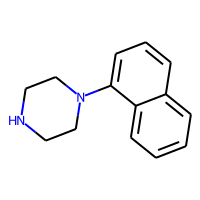
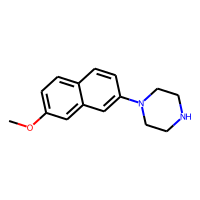
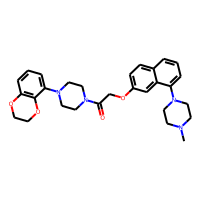
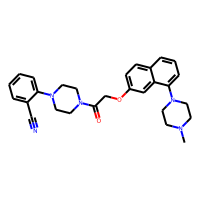
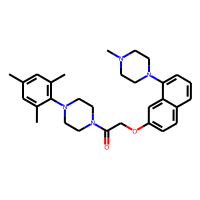

In [44]:
tid = 'CHEMBL1898'
mcsDict = pickle.load(open(f'./ChEMBL_ki/{tid}_ClusterData_UPGMA2.pkl','rb'))
df = pickle.load(open(f'./ChEMBL_ki/{tid}_moldata_UPGMA2.pkl','rb'))
df.head()

In [48]:
def remove_ring_smarts(sma):
    return sma.replace('&!R','').replace('&R','').replace('&@','').replace('&!@','')

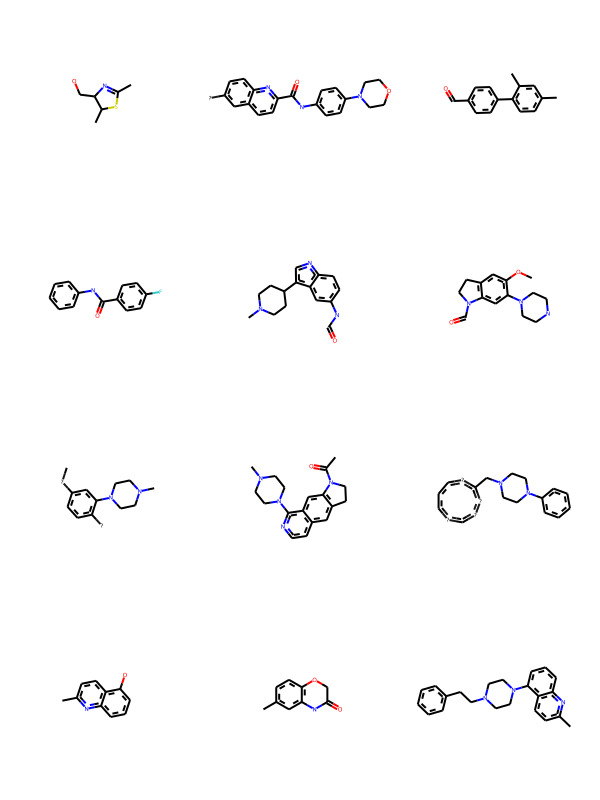

In [50]:
scaffMols = []
lbls = []
for k,v in mcsDict.items():
    lbls.append(k)
    sma = remove_ring_smarts(v[-2])
    m = Chem.MolFromSmarts(sma)
    m.UpdatePropertyCache(False)
    Chem.GetSymmSSSR(m)
    rdDepictor.Compute2DCoords(m)
    scaffMols.append(m)
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.prepareMolsBeforeDrawing = False
Draw.MolsToGridImage(scaffMols)

In [49]:
remove_ring_smarts(sma)

'[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#7]:1):[#6]:[#6]:[#6]:[#6]:2-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1'

In [72]:
UPGMAClassification.moldata_proj['chembl_id']

0      CHEMBL365695
1      CHEMBL360384
2      CHEMBL184855
3      CHEMBL367812
4      CHEMBL186646
           ...     
398     CHEMBL60153
399    CHEMBL261145
400    CHEMBL494803
401     CHEMBL71917
402    CHEMBL494803
Name: chembl_id, Length: 403, dtype: object

In [73]:
UPGMAClassification.MolAssignment[774]

[285,
 300,
 286,
 301,
 287,
 302,
 288,
 289,
 304,
 305,
 291,
 292,
 382,
 278,
 294,
 280,
 297,
 298]

In [81]:
UPGMAClassification.moldata_proj['ClusterID'].iloc[[0,2,4]].map(lambda x:x.append(4))


0    [4]
2    [4]
4    [4]
Name: ClusterID, dtype: object

In [86]:
slf = UPGMAClassification
slf.moldata_proj['ClusterID'] = [[] for x in range(len(slf.moldata_proj))]
for k in slf.MolAssignment.keys():
    slf.moldata_proj['ClusterID'].iloc[slf.MolAssignment[k]].map(lambda x: x.append(k))

,chembl_id,canonical_smiles,standard_relation,standard_value,pchembl_value,doc_id,Molecule,FP,ClusterID
0,CHEMBL365695,CCNc1nc(-c2c(C)n(Cc3c(F)cccc3F)c(=O)n(C[C@H](N...,=,270.0,6.57,20175,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[794]
1,CHEMBL360384,Cc1c(-c2csc(N3CCOCC3)n2)c(=O)n(C[C@H](N)c2cccc...,=,1500.0,5.82,20175,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[794]
2,CHEMBL184855,Cc1c(-c2csc(Nc3ccccc3)n2)c(=O)n(C[C@H](N)c2ccc...,=,70.0,7.16,20175,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[794]
3,CHEMBL367812,Cc1c(-c2csc(N(C)c3ccccc3)n2)c(=O)n(C[C@H](N)c2...,=,34.0,7.47,20175,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[794]
4,CHEMBL186646,Cc1c(-c2csc(NCc3ccccc3)n2)c(=O)n(C[C@H](N)c2cc...,=,35.0,7.46,20175,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[794]

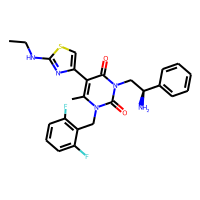
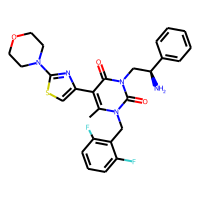
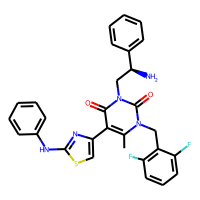
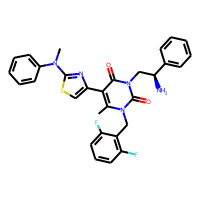
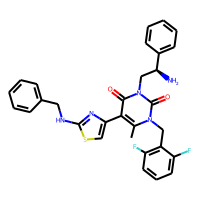

In [87]:
UPGMAClassification.moldata_proj.head()


In [35]:
ms = [Chem.MolFromSmiles(x) for x in moldata.canonical_smiles]

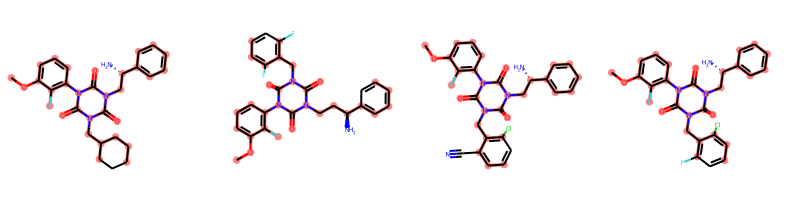

In [54]:
cidx = 774
clust = [ms[x] for x in UPGMAClassification.MolAssignment[cidx]]
scaff = Chem.MolFromSmarts(UPGMAClassification.MCSdict[cidx][-2])
hats = []
for m in clust:
        hats.append(m.GetSubstructMatch(scaff))
Draw.MolsToGridImage(clust[:4],molsPerRow=4,highlightAtomLists=hats[:4])

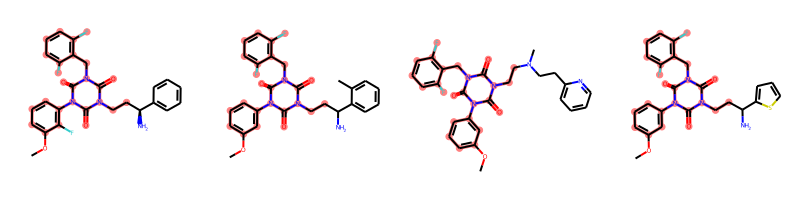

In [55]:
cidx = 767
clust = [ms[x] for x in UPGMAClassification.MolAssignment[cidx]]
scaff = Chem.MolFromSmarts(UPGMAClassification.MCSdict[cidx][-2])
hats = []
for m in clust:
        hats.append(m.GetSubstructMatch(scaff))
Draw.MolsToGridImage(clust[:4],molsPerRow=4,highlightAtomLists=hats[:4])

In [64]:
cids = list(UPGMAClassification.MolAssignment.keys())
for i in range(len(cids)):
    si = set(UPGMAClassification.MolAssignment[cids[i]])
    for j in range(i+1,len(cids)):
        sj = set(UPGMAClassification.MolAssignment[cids[j]])
        overlap = si.intersection(sj)
        print(f'{cids[i]}:{len(si)} {cids[j]}:{len(sj)} {len(overlap)}')

800:39 797:61 0
800:39 787:198 0
800:39 794:260 0
800:39 774:18 0
800:39 767:26 0
797:61 787:198 0
797:61 794:260 3
797:61 774:18 0
797:61 767:26 0
787:198 794:260 197
787:198 774:18 0
787:198 767:26 0
794:260 774:18 0
794:260 767:26 0
774:18 767:26 5


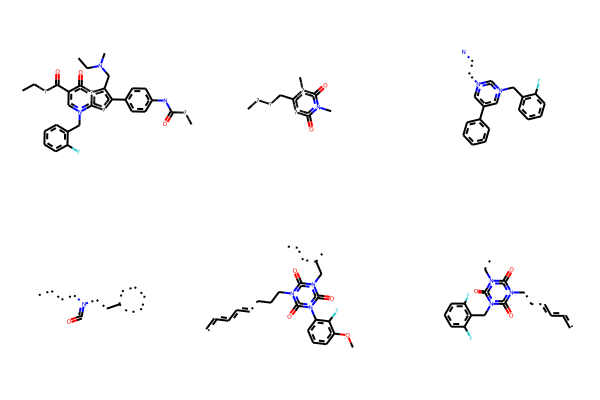

In [97]:
scaffMols = []
lbls = []
for k,v in UPGMAClassification.MCSdict.items():
    lbls.append(k)
    m = Chem.MolFromSmarts(v[-2])
    m.UpdatePropertyCache(False)
    Chem.GetSymmSSSR(m)
    rdDepictor.Compute2DCoords(m)
    scaffMols.append(m)
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.prepareMolsBeforeDrawing = False
Draw.MolsToGridImage(scaffMols)

In [ ]:
dopts.prepareMolsBeforeDrawing

### Benchmark against human-defined classification (seriescolumn is the column with the human series assignment to each molecule in the dataframe moldata)

In [19]:
UPGMAClassification.CalculatePerformance(seriescolumn='series assignment')

In [20]:
moldata_proj=UPGMAClassification.moldata_proj
ProjectClusters=UPGMAClassification.MCSdict
PerformanceClusters=UPGMAClassification.PerformanceClusters

,ID,Structure,mol name,scaffold,series assignment,assay,Molecule,FP,ClusterID
29,29,C#CCNc(cc1)nc(n1)NC(C)(C)C(=O)OC,mol_30,Scaffold_05,['Scaffold_10'],-53.170000,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[6263]
30,30,C#CCNc(n1)c(C)cnc1Nc(cc2C)c(Cl)cc2,mol_31,Scaffold_05,['Scaffold_10'],-54.760000,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[6322, 6263]"
31,31,C#CCNc(n1)cc(C)nc1Nc(cc2)c(CO)cc2C,mol_32,Scaffold_05,['Scaffold_10'],-36.150000,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[6322, 6263]"
32,32,C#CCNc(n1)ccnc1Nc(cc2)c(C)c(c2)F,mol_33,Scaffold_05,['Scaffold_10'],-36.050000,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[6263]
33,33,C#CCNc(n1)ncc(C)c1Nc(cc2C)c(O)cc2,mol_34,Scaffold_05,['Scaffold_09'],-45.740000,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[6351]
...,...,...,...,...,...,...,...,...,...
17522,17522,c1ncc(Br)cc1\C(N2)=C\C(=O)[n]3ncc(c23)c4ccc[s]4,mol_17523,Scaffold_10,[],102.932200,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]
17526,17526,c1ncc[n]1CCC[n]2cncc2c(cc34)ccc3OCO4,mol_17527,Scaffold_01,[],-12.432020,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]
17529,17529,c1ncccc1CC[n]2cncc2c(ccc34)cc3OCO4,mol_17530,Scaffold_01,[],-14.274841,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]
17531,17531,c1ncccc1N(C2=O)C(=O)Nc3n[nH]cc23,mol_17532,Scaffold_12,[],-32.969697,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,[]

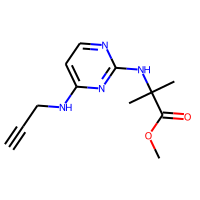
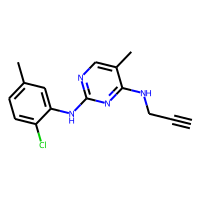
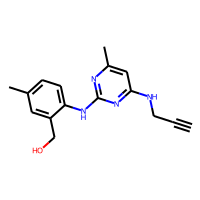
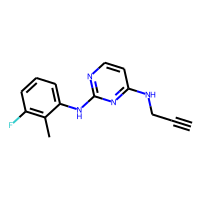
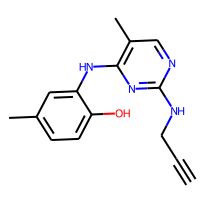
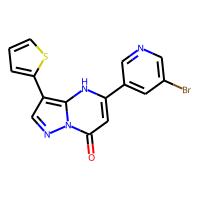
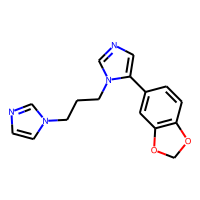
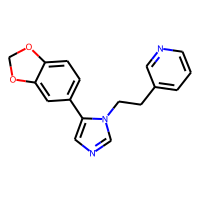
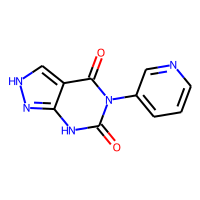
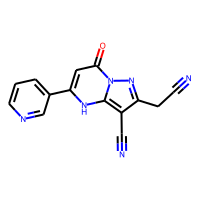

In [21]:
moldata_proj

### Calculate performance metrics

In [22]:
Nmol=len(moldata_proj)
Nrep=sum(moldata_proj['ClusterID'].map(lambda x: len(x)).tolist())
Nunassigned=len(moldata_proj.loc[moldata_proj['ClusterID'].map(lambda x: len(x)==0)])
frac_assigned=(Nmol-Nunassigned)/Nmol
a=Nrep/(Nmol-Nunassigned)
print('fraction of assigned molecules:',frac_assigned,', ambiguity score:',a)

fraction of assigned molecules: 0.19014747411358646 , ambiguity score: 1.3993399339933994


### Plot benchmarking between automatically identified and human defined series

rearrange performance results

In [23]:
scaflist=list(set(moldata_proj['scaffold'].tolist()))
scaflist.sort()
N_auto_series=len(PerformanceClusters['recall'])
LinkVector=PerformanceClusters['linked series']

dict_recall={LinkVector[ind,0]:np.zeros(len(scaflist)) for ind in range(N_auto_series)}
dict_prec={LinkVector[ind,0]:np.zeros(len(scaflist)) for ind in range(N_auto_series)}
for ind in range(N_auto_series):
    scafind=np.where(np.array(scaflist)==LinkVector[ind,1])
    dict_recall[LinkVector[ind,0]][scafind]=PerformanceClusters['recall'][ind]
    dict_prec[LinkVector[ind,0]][scafind]=PerformanceClusters['precision'][ind]
    
keylist=LinkVector[:,0].tolist()
keylist.sort()
dict_recall_sorted={k:dict_recall[k] for k in keylist}
dict_prec_sorted={k:dict_prec[k] for k in keylist}

In [24]:
PerformanceClusters

{'recall': array([0.05594406, 1.        , 0.04195804, 0.12587413, 0.2027972 ,
        0.58333333, 0.3       , 0.7       , 0.5       , 1.        ,
        1.        , 0.22222222, 0.7804878 , 0.00775194, 0.02097902,
        0.02439024, 0.        , 0.04878049, 0.06410256, 0.19512195,
        0.99224806, 0.66666667, 0.69047619, 1.        , 0.04195804,
        0.22222222, 0.        , 0.11111111, 0.88888889, 0.13333333,
        0.875     , 0.5       , 0.05426357, 0.60839161, 0.41025641,
        0.38461538, 0.02222222, 0.0979021 , 0.61538462, 0.02564103]),
 'precision': array([0.53333333, 0.18587361, 0.31578947, 0.64285714, 0.41428571,
        0.20502092, 0.26086957, 0.25454545, 0.16470588, 0.17834395,
        0.125     , 0.16666667, 0.16580311, 0.02      , 0.06521739,
        0.06666667, 0.        , 0.14285714, 0.25      , 0.34782609,
        0.23315118, 0.22222222, 0.21886792, 0.18502203, 0.42857143,
        0.16666667, 0.        , 0.05882353, 0.25      , 0.10344828,
        0.14893617, 0.1

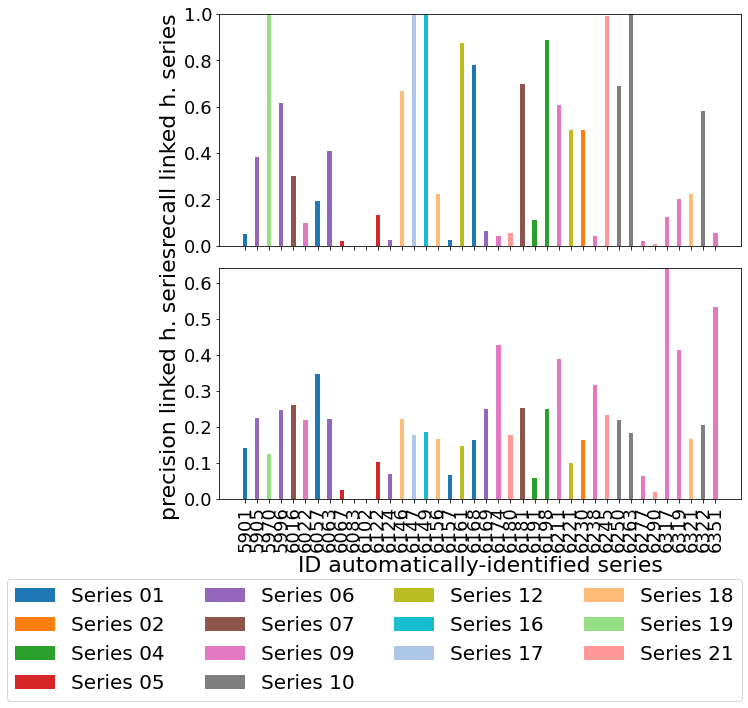

In [25]:
legend=['Series '+s[-2:] for s in scaflist]
rcParams.update({'figure.autolayout': True})
fig,ax=plt.subplots(2,1,figsize=(10,10))
fig,_=utilsDrawing.barplot_vertical(fig, ax[0],dict_recall_sorted,'recall linked h. series',[],['']*len(keylist),1.02)
fig,_=utilsDrawing.barplot_vertical(fig, ax[1],dict_prec_sorted,'precision linked h. series',legend,keylist,1.02)
ax[1].set_xlabel('ID automatically-identified series',fontsize=22)
plt.show()

### Draw MCS of automatically-identified series and linked human-defined series

In [44]:
imp.reload(utilsDrawing)
def renderMCS(seriesid,newscafslist,newscafsnames,linkedscafslist,linkedscafsnames):
    listid=np.where(np.array(newscafsnames)==seriesid)[0][0]
    svg_new=utilsDrawing.moltosvg(Chem.MolFromSmarts(newscafslist[listid]), molSize=(450,250))
    svg_linked=utilsDrawing.moltosvg(Chem.MolFromSmarts(linkedscafslist[listid]), molSize=(450,250))
    labels=[newscafsnames[listid],linkedscafsnames[listid]]
    svgGrid = utilsDrawing.SvgsToGrid([svg_new,svg_linked], labels=labels, svgsPerRow=2, molSize=(450,250))
    return(SVG(svgGrid))

In [45]:
datapath

'./CDK2Kinase/'

In [46]:
seriesdata_proj=pd.read_csv('{0}seriesdata.csv'.format(datapath))
LinkVector_sorted=np.array([[x,y] for x,y in sorted(zip(LinkVector[:,0],LinkVector[:,1]))])
linkedScafsList=[seriesdata_proj['MCSsampled'].loc[seriesdata_proj['ScafName']==x].iloc[0] for x in LinkVector_sorted[:,1]]
linkedScafsNames=[x for x in LinkVector_sorted[:,1]]
MCSlist=[ProjectClusters[int(k)][2] for k in keylist]

interact(renderMCS, seriesid=keylist, newscafslist=fixed(MCSlist),newscafsnames=fixed(keylist),linkedscafslist=fixed(linkedScafsList),linkedscafsnames=fixed(linkedScafsNames));


interactive(children=(Dropdown(description='seriesid', options=('5901', '5905', '5970', '5996', '6016', '6022'…

### 10fold cross-validation by sampling 40% of all compounds

In [ ]:
fraction_sample=0.4
N_sample=10
start=time.clock()
UPGMAClassification.ClassificationCrossValidation(fraction_sample, N_sample)
end=time.clock()
print("Time elapsed during the calculation:", end - start)   

In [ ]:
UPGMAClassification.EvaluationCrossValidation()

In [ ]:
rcParams.update({'figure.autolayout': True})
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.boxplot(x="series id", y="fscore", data=UPGMAClassification.EvalCrossval, color=[0.5,0.6,1.0],ax=ax)
ax.set_ylabel('F$_1$ score',fontsize=26)
ax.set_xlabel('series ID',fontsize=26)

plt.setp(ax.get_xticklabels(), fontsize=22, rotation='vertical')
plt.setp(ax.get_yticklabels(), fontsize=22)
plt.show()